# Introduction - Photo Caption Generator using CNN and LSTM in Keras

We will develop a CNN and LSTM model to train the model by providing a set of images with predefined captions. Once we train the model we will use to generate captions for new images.

We will break down the rest of the document into folowing categories:

* Data Exploration
* Build and fit the model
* Predict captions 

## Data Exploration
For photo images with predefined captions, we are using Flickr8K dataset. The dataset has 6,000 training images, and 1,000 test images with captions. It contains two set of directories as described below.

* Flicker8k_Dataset - 8000 images 
* Flickr8k_text - It contains following files:
  - Flickr8k.token - It contains image file name with upto 5 captions per image
  - Flickr_8k.devImages.txt - conatins training image file names
  - Flickr_8k.testImages.txt - conatins testing image file names

## Build the Model
We use pretrained VGG16 model to extract the features of the image. VGG16 is a convolutional neural 
network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper ["Very Deep Convolutional Networks for Large-Scale Image Recognition"](http://www.robots.ox.ac.uk/~vgg/research/very_deep/).
The model achieves \(\ 92.7% \) top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.

<img src="screenshots/vgg16.png">

The model inspiration for caption generator originates from the "merge-model" described by Marc Tanti paper:[What is the Role of Recurrent Neural Networks (RNNs) in an Image Caption Generator?](https://arxiv.org/abs/1708.02043)    
The model from the paper is represented below:
<img src="screenshots/mergemodel.png">

In [36]:
#Import the libraries
import re
import string
import os
import itertools
from numpy import array
from numpy import argmax
from pickle import dump, load
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras import optimizers
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [4]:
#Data Exploration - Token File - output sample lines
filename = "Flickr8k_text/Flickr8k.token.txt"
with open(filename) as myfile:
    for i in range(10):
        line = myfile.readline()
        print(line)

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .

1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .

1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .

1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .

1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting

1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .

1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .

1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .

1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .



#### Define utility functions for cleaning  the captions. 

In [5]:
#Read file
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    #print(type(text))
    # close the file
    file.close()
    return text

In [6]:
# Load Pre-defined list of image ids
def load_imageids(filename):
    doc = load_doc(filename)
    dataset = list()
    
    # Process image ids
    for line in doc.split('\n'):
        
        # Skip empty lines
        if len(line) < 1:
            continue
        
        # Get the image identifier
        imageid = line.split('.')[0]
        dataset.append(imageid)
    return set(dataset)

In [7]:
# Clean up captions
def load_clean_captions(captionsfile, dataset):
    
    doc = load_doc(captionsfile)
    
    captions = dict()
    i = 0
    
    for line in doc.split('\n'):
        
        # Split line
        tokens = line.split()
        
        #Exclude where no captions are provided
        if len(tokens) < 2:
            continue
        
        # Split image id from caption
        image_id, caption = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        
        # Skip images not in the set
        if image_id in dataset:  
            #Regex for punctuations and non-printable characters 
            re_punc = re.compile('[%s]' % re.escape(string.punctuation))
            re_print = re.compile('[^%s]' % re.escape(string.printable))

            # Convert it to string
            caption = ' '.join(caption)
            
            # Tokenize on white space
            caption = caption.split()
            
            # Convert to lowercase
            caption = [word.lower() for word in caption]
            
            # Remove punctuation from each token
            caption = [re_punc.sub('', w) for w in caption]
            
            # Remove non-printable chars form each token
            caption = [re_print.sub('', w) for w in caption]
            
            # Remove tokens with numbers in them
            caption = [word for word in caption if word.isalpha()]
            
            # Remove one letter words like 'a'
            caption = [word for word in caption if len(word)>2]
            
            # If this is a new image id
            if image_id not in captions:
                captions[image_id] = list()

            # Add delimiters to start and end of a caption
            caption = 'startseq ' + ' '.join(caption) + ' endseq'   

            # Append all 0-4 descriptions of an image together. The key is the image_id.    
            captions[image_id].append(caption)  
        
    return captions

In [10]:
# Load trainig dataset
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_imageids(filename)

# Total images in training set    
print('Number of images in Training set: %d' % len(train))

# Load captions for training images
train_captions = load_clean_captions('Flickr8k_text/Flickr8k.token.txt', train)
print('Number of captions per image id in Training set: %d' % len(train_captions))

Number of images in Training set: 6000
Number of captions per image id in Training set: 6000


All the captions have been cleaned and preprocessed and have a statseq and endseq markers added for the LSTM model. All the captions are stored in a dictionary using imageid as the key. Few such samples are shown below.

In [13]:
#Sample train set
print(train_captions["1000268201_693b08cb0e"])

['startseq child pink dress climbing set stairs entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs her playhouse endseq', 'startseq little girl pink dress going into wooden cabin endseq']


In [15]:
#Sample train set
print(train_captions["1001773457_577c3a7d70"])

['startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tricolored dog playing with each other the road endseq', 'startseq black dog and white dog with brown spots are staring each other the street endseq', 'startseq two dogs different breeds looking each other the road endseq', 'startseq two dogs pavement moving toward each other endseq']


In [8]:
# Save captions to a file, one per line
def save_captions(captions, filename):
    lines = list()
    for key, desc_list in captions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    
# save to file
save_captions(train_captions, 'captions.txt')


In [9]:
#Print first five image ids with captions
first5pairs = {k: train_captions[k] for k in list(train_captions.keys())[:5]}
print(first5pairs)

{'1000268201_693b08cb0e': ['startseq child pink dress climbing set stairs entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs her playhouse endseq', 'startseq little girl pink dress going into wooden cabin endseq'], '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tricolored dog playing with each other the road endseq', 'startseq black dog and white dog with brown spots are staring each other the street endseq', 'startseq two dogs different breeds looking each other the road endseq', 'startseq two dogs pavement moving toward each other endseq'], '1002674143_1b742ab4b8': ['startseq little girl covered paint sits front painted rainbow with her hands bowl endseq', 'startseq little girl sitting front large painted rainbow endseq', 'startseq small girl the grass plays with fingerpaints front white canvas with rai

Load the VGG15 pre-trained model and pop out the last classification layer as we will learn the features for the Flicke Dataset using VGG16 model. The model expects images as input with the size 224 x 224 pixels with 3 channels.

In [11]:
# Load VGG model in keras. 
# The model expects images as input with the size 224 x 224 pixels with 3 channels (e.g. color)
model1 = VGG16()
print(model1.summary())
model1.layers.pop()
model1 = Model(inputs=model1.inputs, outputs=model1.layers[-1].output)

print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Use pretained VGG model to extract features for each photo in the directory. Save the features in a dictionary and to features.pkl file.

In [12]:
# Use pretained VGG model to extract features for each photo in the directory 
def extract_features_VGG(base):
    # Features for each photo
    features = dict()
    
    for name in os.listdir(base):
        
        # Load image 
        filename = os.path.join(base, name)
        image = load_img(filename, target_size=(224, 224))
        
        # Convert image pixels to numpy array for use in Keras
        image = img_to_array(image)
        
        # Reshape for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # Prepare image for the VGG model
        image = preprocess_input(image)
        
        # Get features - predict the probability across all output classes
        feature = model1.predict(image, verbose=0)
        
        # Get image id
        image_id = name.split('.')[0]
        
        # Store feature
        
        
        features[image_id] = feature
            
    return features

In [13]:
# Extract features for the dataset
base = 'Flicker8k_Dataset'
features = extract_features_VGG(base)

In [15]:
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))

print(features["1001773457_577c3a7d70"].shape, features["1001773457_577c3a7d70"])   

Extracted Features: 8091
(1, 4096) [[0.        0.        0.4941089 ... 0.        0.        0.       ]]


Extract the features from the features.pkl file for training images. 

In [18]:
# Load features for training images
def load_photo_features(filename, dataset):
    # Load all features
    all_features = load(open(filename, 'rb'))
    # Filter features
    features = {k: all_features[k] for k in dataset}
    return features

train_features = load_photo_features('features.pkl', train)
print('Train photo features: %d' % len(train_features))

Train photo features: 6000


Use Tokenizer class in Keras to create the vectors for the captions. 

In [19]:
# The captions need to be converted into embeddings 
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(captions):
    all_desc = list()
    for key in captions.keys():
        [all_desc.append(d) for d in captions[key]]
    return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(captions):
    lines = to_lines(captions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [20]:
# prepare tokenizer
tokenizer = create_tokenizer(train_captions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7526


As the LSTM model will need a fixed width vector we will sero pad the tokenizer vectors to match the maximum length of a caption in the dataset. We use create sequences that will be used to feed into one model that will be used to extracting the features of an image and list of vectorized words to LSTM and a known vector of known output of each sample in the training. 

For examply, given a caption like "girl going into wooden building" we will have following input and output pairs ot train the LSTM model as below:

X1    |  X2                                             | y


image |  startseq,                                      | girl   
image |  startseq, girl                                 | going   
image |  startseq, girl, going                          | into    
image |  startseq, girl, going, into                    | wooden   
image |  startseq, girl, going, into, wooden            | building   
image |  startseq, girl, going, into, wooden, building  | endseq   

In [21]:
# calculate the length of the description with the most words
def max_length(captions):
    lines = to_lines(captions)
    return max(len(d.split()) for d in lines)

def create_sequences(tokenizer, maxlen, descriptions, photos):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    
    for key, desc_list in descriptions.items():
        #print(key, desc_list)
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            #print(desc, seq)
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=maxlen)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                #print(len(in_seq), len(out_seq))
                
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
            
    return array(X1), array(X2), array(y)

In [22]:
# prepare tokenizer
tokenizer = create_tokenizer(train_captions)
#sample index of the words 
print(tokenizer.texts_to_sequences(["dog horse pink"]))

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# determine the maximum sequence length
maxlen = max_length(train_captions)
print('Description Length: %d' % maxlen)

[[5, 193, 77]]
Vocabulary Size: 7526
Description Length: 28


In [23]:
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, maxlen, train_captions, train_features)

print(X1train.shape, X2train.shape, ytrain.shape)

(263004, 4096) (263004, 28) (263004, 7526)


In [24]:
# load test set
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
test = load_imageids(filename)
print('Dataset: %d' % len(test))
# descriptions
test_captions = load_clean_captions('Flickr8k_text/Flickr8k.token.txt', test)
print('Descriptions: test=%d' % len(test_captions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, maxlen, test_captions, test_features)


Dataset: 1000
Descriptions: test=1000
Photos: test=1000


Define the merge model using CNN-LSTM  for image captioning. 

In [25]:
# define the captioning model
def define_model(vocab_size, maxlen):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(maxlen,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    adam = optimizers.Adam(0.001)
    model.compile(loss='categorical_crossentropy', optimizer=adam)
    # summarize model
    print(model.summary())
    return model

In [26]:
model = define_model(vocab_size, maxlen)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 28, 256)      1926656     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)  

In [27]:
# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
hist = model.fit([X1train, X2train], ytrain, epochs=5, verbose=2, callbacks=[checkpoint], 
                  validation_data=([X1test, X2test], ytest))

Instructions for updating:
Use tf.cast instead.
Train on 263004 samples, validate on 43477 samples
Epoch 1/5
 - 1028s - loss: 4.9012 - val_loss: 4.4888

Epoch 00001: val_loss improved from inf to 4.48876, saving model to model-ep001-loss4.901-val_loss4.489.h5
Epoch 2/5
 - 1005s - loss: 4.2918 - val_loss: 4.3261

Epoch 00002: val_loss improved from 4.48876 to 4.32614, saving model to model-ep002-loss4.292-val_loss4.326.h5
Epoch 3/5
 - 1005s - loss: 4.0817 - val_loss: 4.2857

Epoch 00003: val_loss improved from 4.32614 to 4.28574, saving model to model-ep003-loss4.082-val_loss4.286.h5
Epoch 4/5
 - 1002s - loss: 3.9745 - val_loss: 4.2865

Epoch 00004: val_loss did not improve from 4.28574
Epoch 5/5
 - 1113s - loss: 3.9132 - val_loss: 4.2881

Epoch 00005: val_loss did not improve from 4.28574


Extract the feature for a test image. Use the Tokenizer class in Keras to convert the index back to word. Finally generate the caption using model.predict and passing in the vector for image features along with captions that are generated as part of the sequence model. 

In [31]:
# generate a description for an image
# extract features from each photo in the directory
def extract_features(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, maxlen):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(maxlen):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=maxlen)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text


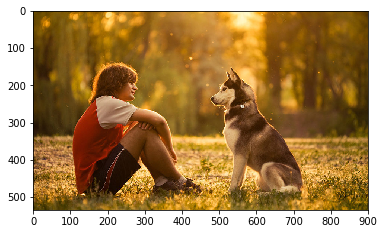

startseq two dogs are playing with each other the grass endseq


In [32]:
img=mpimg.imread('dog-boy.jpg')
imgplot = plt.imshow(img)
plt.show()

photo = extract_features("dog-boy.jpg")
# generate description
description = generate_desc(model, tokenizer, photo, maxlen)
print(description)

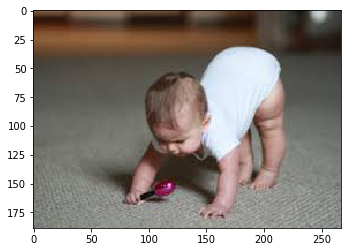

startseq two children are playing with the camera endseq


In [33]:
img=mpimg.imread('baby.jpg')
imgplot = plt.imshow(img)
plt.show()

photo = extract_features("baby.jpg")
# generate description
description = generate_desc(model, tokenizer, photo, maxlen)
print(description)

In [37]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

evaluate_model(model, test_captions, test_features, tokenizer, maxlen)

BLEU-1: 0.191822
BLEU-2: 0.102509
BLEU-3: 0.076239
BLEU-4: 0.029094


### Reference

* [Automatic Image Captioning using Deep Learning (CNN and LSTM) in PyTorch](https://www.analyticsvidhya.com/blog/2018/04/solving-an-image-captioning-task-using-deep-learning/)
* [Develop an image captioning deep learning model using Flickr 8K data](https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html)
* [How to Develop a Deep Learning Photo Caption Generator from Scratch](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/)